## Import Libraries

In [14]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

## Data

### Download

In [15]:
# Define the stock symbol and the date range for our data
stock_symbol = 'GOOGL'
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"MACD Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

MACD Trading for: GOOGL
Start Date: 2000-01-01
End Date: 2024-12-04


In [16]:
df = yf.download(stock_symbol, start=start_date, end=end_date, interval='1wk')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-16,2.703765,2.710460,2.729730,2.401401,2.502503,1349868780
2004-08-23,2.649844,2.656406,2.839840,2.591842,2.771522,1119974904
2004-08-30,2.496571,2.502753,2.639890,2.475976,2.634635,790480728
2004-09-06,2.629375,2.635886,2.666667,2.492743,2.527778,471875652
2004-09-13,2.932928,2.940190,2.940190,2.664164,2.668418,962500536


In [17]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2004-08-16,2.502503,2.710460,1349868780,2.401401,2.729730
2004-08-23,2.771522,2.656406,1119974904,2.591842,2.839840
2004-08-30,2.634635,2.502753,790480728,2.475976,2.639890
2004-09-06,2.527778,2.635886,471875652,2.492743,2.666667
2004-09-13,2.668418,2.940190,962500536,2.664164,2.940190


### Visualize Stock Data

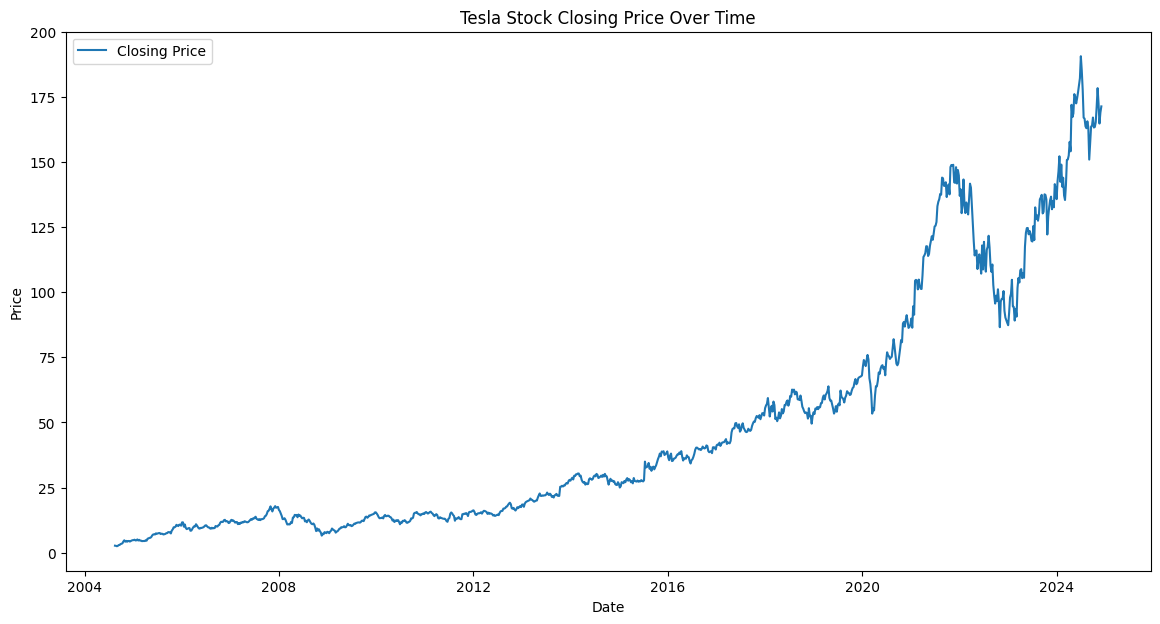

In [18]:
# Plot the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Get Close Prices

In [19]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'Close' column directly and replace it with the scaled values
df['Close'] = scaler.fit_transform(df[['Close']])

# Extract the scaled closing prices into a list
prices = df['Close'].tolist()

# Print the size of the scaled prices list
print(len(prices))

# Print the first 10 scaled prices
print(prices[:10])  # This will display the first 10 scaled values


1060
[0.0011042528524338145, 0.0008168801186537247, 0.0, 0.0007077877661016627, 0.002325589822937728, 0.002636912502707235, 0.004333210048044631, 0.005018382575387722, 0.0058671929977947915, 0.009634972643274013]


In [20]:
window_size = 12
forecast_period = 12

sequences = []

for i in range(len(prices) - window_size - forecast_period + 1):
    window = prices[i:i+window_size]
    forecast = prices[i+window_size:i+window_size+forecast_period]
    sequences.append((window, forecast))

print(sequences)

[([0.0011042528524338145, 0.0008168801186537247, 0.0, 0.0007077877661016627, 0.002325589822937728, 0.002636912502707235, 0.004333210048044631, 0.005018382575387722, 0.0058671929977947915, 0.009634972643274013, 0.012057688084702617, 0.009225201045536889], [0.010908197149582254, 0.00923185303371114, 0.010560952719649207, 0.0106953284578933, 0.009531202641778293, 0.010652754719555506, 0.011693146964482634, 0.012343731181364798, 0.012484753837670202, 0.013298975949616341, 0.01174370613069729, 0.012017773620600643]), ([0.0008168801186537247, 0.0, 0.0007077877661016627, 0.002325589822937728, 0.002636912502707235, 0.004333210048044631, 0.005018382575387722, 0.0058671929977947915, 0.009634972643274013, 0.012057688084702617, 0.009225201045536889, 0.010908197149582254], [0.00923185303371114, 0.010560952719649207, 0.0106953284578933, 0.009531202641778293, 0.010652754719555506, 0.011693146964482634, 0.012343731181364798, 0.012484753837670202, 0.013298975949616341, 0.01174370613069729, 0.0120177736

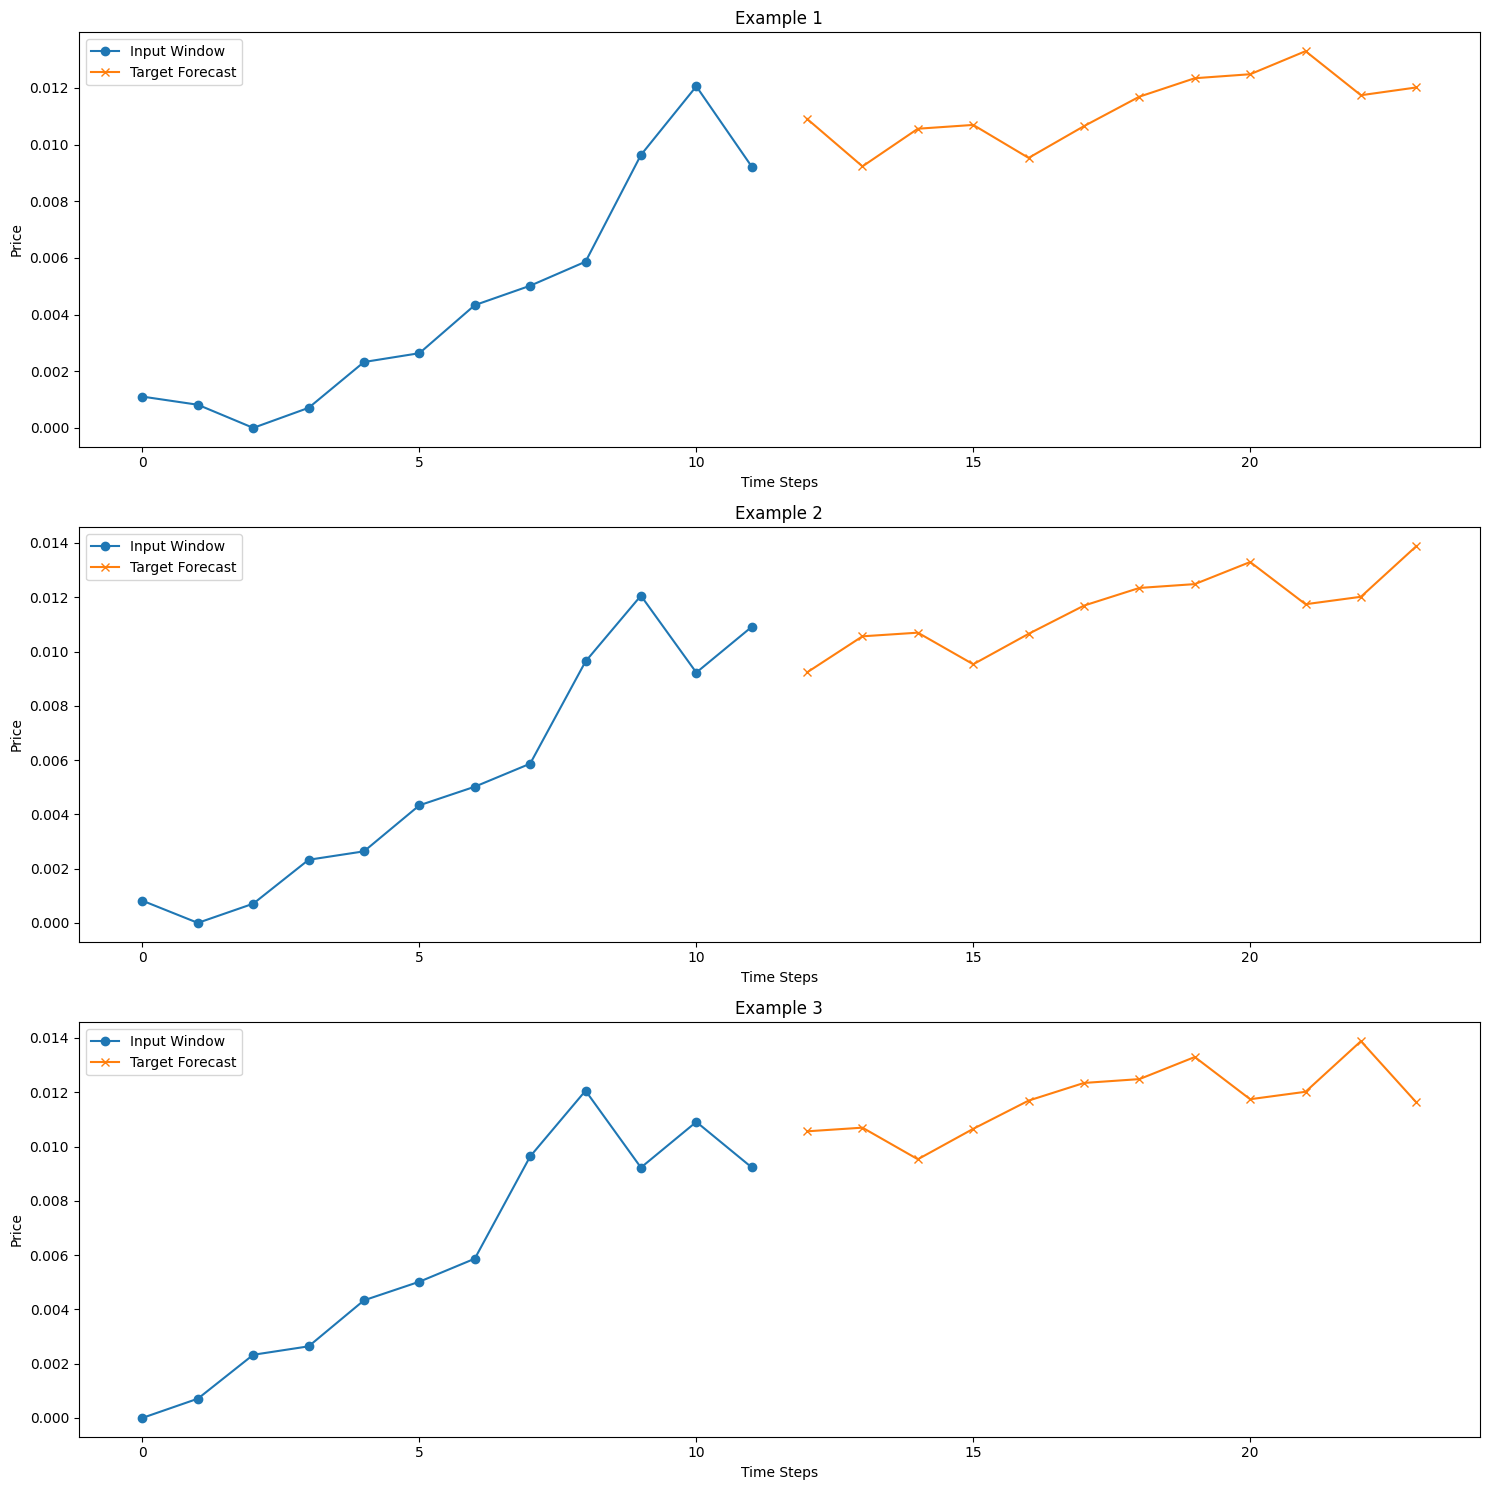

In [21]:
# Plot a few examples of the input windows and their corresponding forecasts
def plot_sequences(sequences, num_examples=3):
    """
    Plots a few input and target sequences.

    Parameters:
    - sequences: List of (input_window, target_forecast) tuples.
    - num_examples: Number of examples to plot.
    """
    plt.figure(figsize=(15, 5 * num_examples))  # Adjust size for multiple plots

    for i in range(num_examples):
        # Get input window and target forecast
        input_window, target_forecast = sequences[i]

        # Create x-values for plotting
        input_x = range(len(input_window))
        forecast_x = range(len(input_window), len(input_window) + len(target_forecast))

        # Create subplots
        plt.subplot(num_examples, 1, i + 1)
        plt.plot(input_x, input_window, label='Input Window', marker='o')
        plt.plot(forecast_x, target_forecast, label='Target Forecast', marker='x')
        
        # Add titles, labels, and legend
        plt.title(f"Example {i + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the sequences
plot_sequences(sequences, num_examples=3)


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert sequences into X (inputs) and Y (targets)
X = np.array([seq[0] for seq in sequences])  # Input windows
y = np.array([seq[1] for seq in sequences])  # Target forecasts

# Reshape the input data to match LSTM's expected shape (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)  # (num_samples, window_size, 1)
y = y.reshape(y.shape[0], y.shape[1], 1)  # (num_samples, forecast_period, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (829, 12, 1)
y_train shape: (829, 12, 1)
X_test shape: (208, 12, 1)
y_test shape: (208, 12, 1)


In [23]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50))  # LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(units=forecast_period))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_test, y_test), 
        epochs=20, 
        batch_size=32, 
        verbose=1
    )


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\LSTM_stock_forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0179 - val_loss: 0.0573
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0082
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8351e-04 - val_loss: 0.0061
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2923e-04 - val_loss: 0.0061
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.5939e-04 - val_loss: 0.0057
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4747e-04 - val_loss: 0.0060
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9605e-04 - val_loss: 0.0056
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.5174e-04 - val_loss: 0.0059
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")


Train Loss: 0.00028377267881296575
Test Loss: 0.006251040380448103


In [25]:
# Make predictions on the test set
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


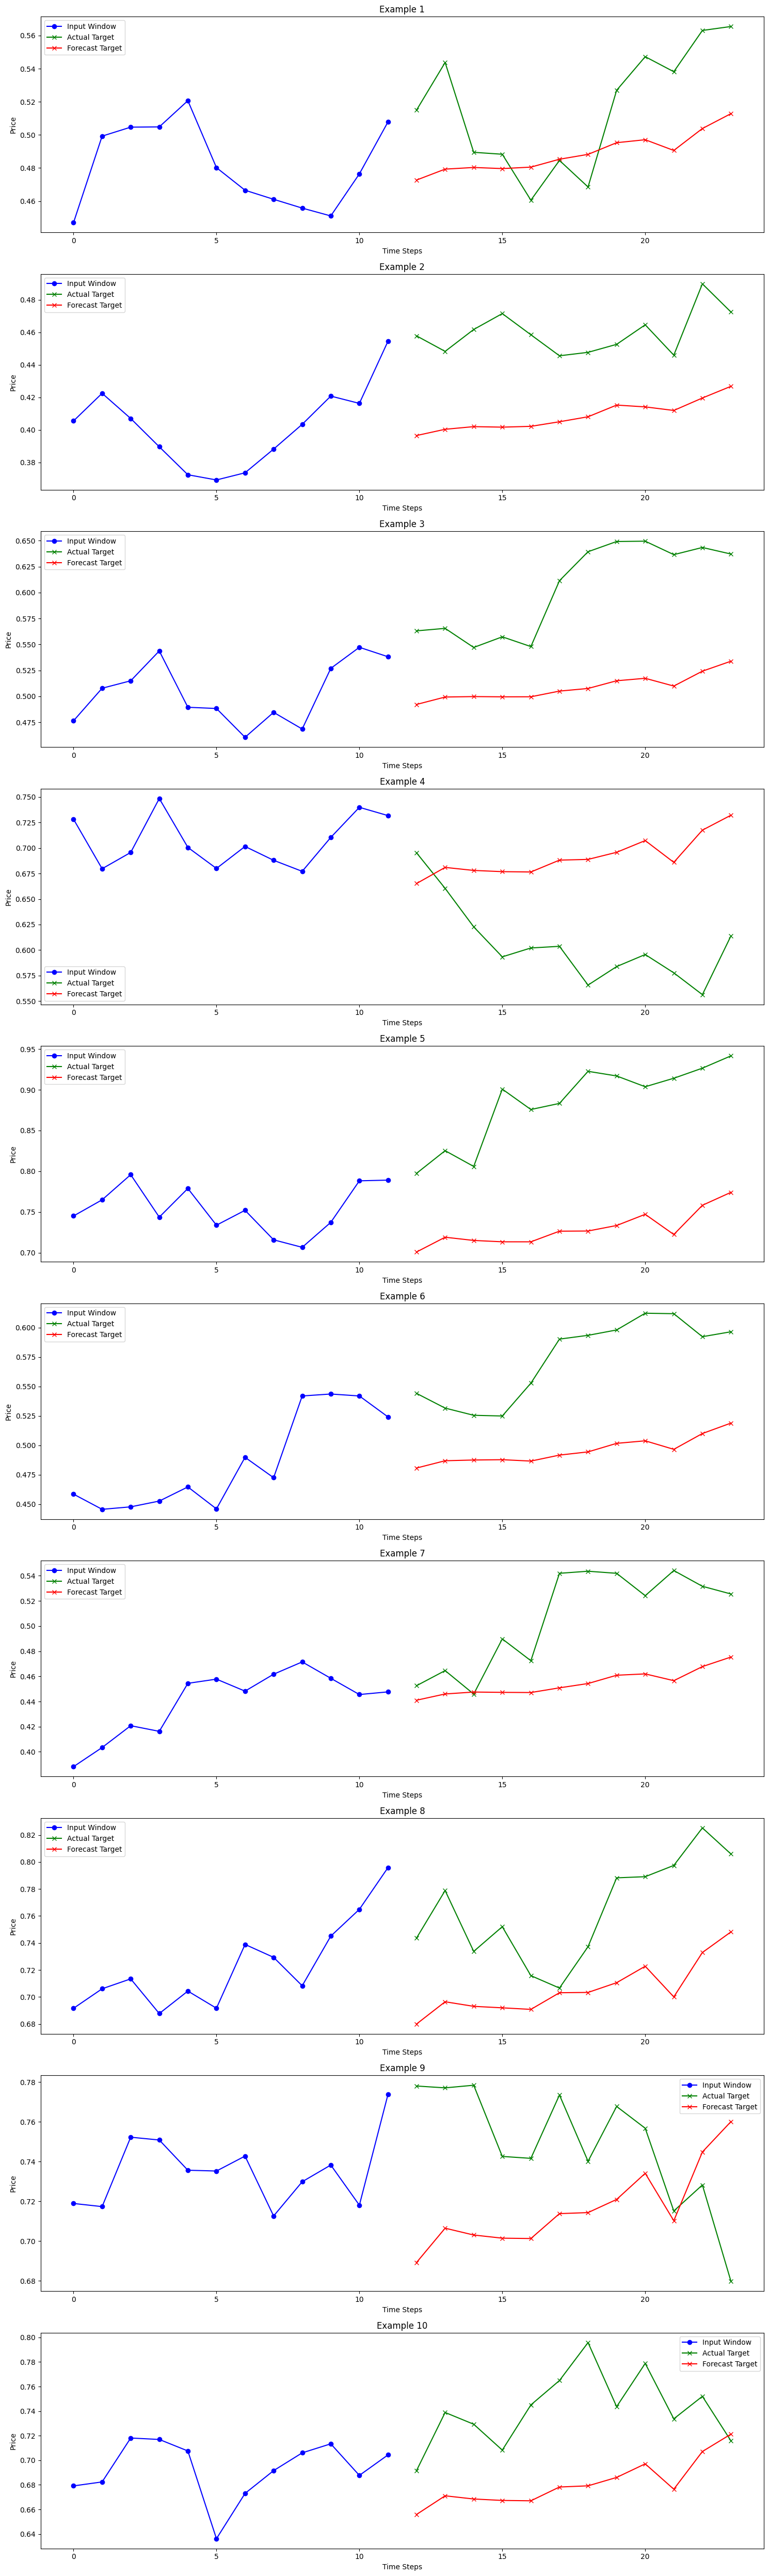

In [27]:
import random
import matplotlib.pyplot as plt

# Function to plot input data, actual target, and forecast target
def plot_input_actual_forecast(input_data, actual_target, forecast_target, num_examples=3):
    """
    Plots the input data (window), actual target, and forecast target on the same plot.
    
    Parameters:
    - input_data: The input window sequence for the LSTM.
    - actual_target: The actual future values we want to predict.
    - forecast_target: The predicted future values from the LSTM model.
    - num_examples: The number of examples to plot.
    """
    plt.figure(figsize=(15, 5 * num_examples))  # Adjust size for multiple plots

    # Randomly select indices from the test set
    random_indices = random.sample(range(len(input_data)), num_examples)

    for i in random_indices:
        input_window = input_data[i]
        actual = actual_target[i]
        predicted = forecast_target[i]

        # Create x-values for plotting
        input_x = range(len(input_window))
        actual_x = range(len(input_window), len(input_window) + len(actual))
        predicted_x = range(len(input_window), len(input_window) + len(predicted))

        # Create subplots
        plt.subplot(num_examples, 1, random_indices.index(i) + 1)
        plt.plot(input_x, input_window, label='Input Window', marker='o', color='blue')
        plt.plot(actual_x, actual, label='Actual Target', marker='x', color='green')
        plt.plot(predicted_x, predicted, label='Forecast Target', marker='x', color='red')
        
        # Add titles, labels, and legend
        plt.title(f"Example {random_indices.index(i) + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot random input, actual, and forecasted values
plot_input_actual_forecast(X_test, y_test, y_pred, num_examples=10)
